In [ ]:
import math
import numpy as np
import pandas as pd
import glob
import os
import pickle

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from keras.regularizers import *
from tensorflow.keras.optimizers import Adagrad, Adam, Adamax, Nadam, Optimizer, RMSprop, SGD, schedules 
from keras.models import Sequential, Model
from keras.layers import ConvLSTM2D, Conv3D, Conv2D, Conv1D, LSTM, Dense, TimeDistributed, Input, Dropout, Activation, Flatten, BatchNormalization, Masking
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import jaccard_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight

from enum import Enum 
import random as rn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = np.load('/content/drive/MyDrive/google_colab_skeleton/submodel/X_train.npy') 
X_val = np.load('/content/drive/MyDrive/google_colab_skeleton/submodel/X_val.npy') 
y_train = np.load('/content/drive/MyDrive/google_colab_skeleton/submodel/y_train.npy') 
y_val = np.load('/content/drive/MyDrive/google_colab_skeleton/submodel/y_val.npy') 


In [ ]:
X_train_sub = np.concatenate((X_train[y_train[:,0]==1], X_train[y_train[:,1]==1]), axis = 0)
y_train_sub = np.concatenate((y_train[y_train[:,0]==1], y_train[y_train[:,1]==1]), axis = 0)
y_train_sub = y_train_sub[:,0:2]

X_val_sub = np.concatenate((X_val[y_val[:,0]==1], X_val[y_val[:,1]==1]), axis = 0)
y_val_sub = np.concatenate((y_val[y_val[:,0]==1], y_test[y_val[:,1]==1]), axis = 0)
y_val_sub = y_val_sub[:,0:2]

In [ ]:
padded_X_sub = X_train_sub[:,:,:,:,0:4].reshape(120, 289, 18, 4)
featured_X_sub = X_train_sub[:,:,:,:,4:8].reshape(120, 289, 72)
padded_X_val_sub = X_val_sub[:,:,:,:,0:4].reshape(34, 289, 18, 4)
featured_X_val_sub = X_val_sub[:,:,:,:,4:8].reshape(34, 289, 72)

In [ ]:
def angle_features(X):
  F_ANG = []
  for s in range(len(X)):
    sample = X[s,:,:,:,]
    F_ANG_sample = []

    
    for t in range(len(sample)):
      frame = sample[t,:,:]

      # Let- ϴ is the angle AOB: A, O, B are keypoints; A = (ax, ay), B = (bx, by), and O = (ox, oy)
      # ϴ = tan^(-1) ( ((ax-ox)*(by-oy)+(ay-oy)*(bx-ox)) / ((ax-ox)*(bx-ox)-(ay-oy)*(by-oy)) )
      # for ϴ1-----keypoints: 9,3,4
      # for ϴ2-----keypoints: 3,4,5
      # for ϴ3-----keypoints: 6,7,8
      # for ϴ4-----keypoints: 12,6,7
      # for ϴ5-----keypoints: 12,9,10 
      # for ϴ6-----keypoints: 9,12,13
      # for ϴ7-----keypoints: 9,10,11
      # for ϴ8-----keypoints: 12,13,14
    
      keypoints = [[9,3,4], [3,4,5], [6,7,8], [12,6,7], [12,9,10], [9,12,13], [9,10,11], [12,13,14]]
      F_ANG_frame = []
        
      for k in keypoints:
        F_angles = []
        d = ((frame[k[0],1]-frame[k[1],1])*(frame[k[2],1]-frame[k[1],1]) -
                                    (frame[k[0],2]-frame[k[1],2])*(frame[k[2],2]-frame[k[1],2]))
        
        ϴ = math.degrees(math.atan( 
            ((frame[k[0],1]-frame[k[1],1])*(frame[k[2],2]-frame[k[1],2])        
             +(frame[k[0],2]-frame[k[1],2])*(frame[k[2],1]-frame[k[1],1])
                                   ) 
                                   / (d + 0.0000001) ))
        ϴ = ϴ / 180
        F_angles.append(ϴ)

        F_ANG_frame.append(F_angles)      
      F_ANG_sample.append(F_ANG_frame)
    F_ANG.append(F_ANG_sample)
  return np.array(F_ANG)

    

In [ ]:
F_ANG_sub = angle_features(padded_X_sub).reshape(146, 289, 8)
F_ANG_val_sub = angle_features(padded_X_val_sub).reshape(34, 289, 8)

In [ ]:
X_train_sub = np.concatenate((F_ANG_sub, featured_X_sub), axis = 2)
X_val_sub = np.concatenate((F_ANG_val_sub, featured_X_val_sub), axis = 2)
X_test_sub = np.concatenate((F_ANG_test_sub, featured_X_test_sub), axis = 2)
X_train_sub = np.concatenate((X_train_sub, X_val_sub), axis = 0)

In [ ]:
y_train_sub = np.concatenate((Y_sub, y_val_sub), axis = 0)

In [ ]:
def sub_model():
    model = Sequential()
    
    model.add(Masking(mask_value=0.))
    model.add(LSTM(filter_size, recurrent_dropout=dropout, return_sequences=True, activation="sigmoid", kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Masking(mask_value=0.))
    model.add(LSTM(filter_size, recurrent_dropout=dropout, return_sequences=True, activation="sigmoid", kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Masking(mask_value=0.))
    model.add(LSTM(filter_size, recurrent_dropout=dropout, return_sequences=True, activation="sigmoid", kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())

    model.add(Flatten())
    
    model.add(Dense(2*filter_size, activation="sigmoid",  kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dense_dropout))

    model.add(Dense(2, activation = "softmax"))

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 289, 80)           0         
                                                                 
 lstm (LSTM)                 (None, 289, 400)          769600    
                                                                 
 batch_normalization (BatchN  (None, 289, 400)         1600      
 ormalization)                                                   
                                                                 
 masking_1 (Masking)         (None, 289, 400)          0         
                                                                 
 lstm_1 (LSTM)               (None, 289, 400)          1281600   
                                                                 
 batch_normalization_1 (Batc  (None, 289, 400)         1600      
 hNormalization)                                        

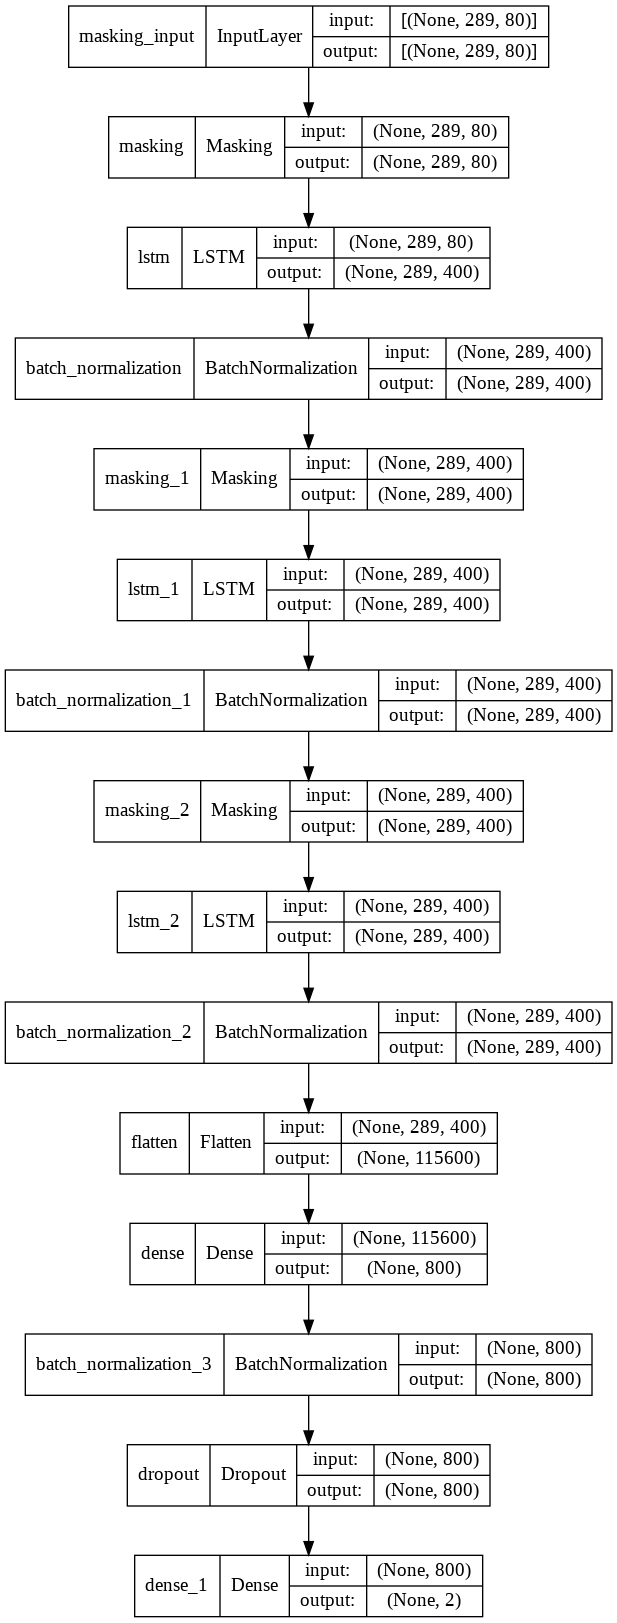

In [ ]:
dropout = 0.9
dense_dropout = 0.9
filter_size = 400
plot_model = sub_model()
plot_model.build(input_shape=(None, 289, 80)) 
plot_model.summary()
tf.keras.utils.plot_model(plot_model, to_file="plot_model.png", show_shapes=True)

In [ ]:
def plot_acc(model_path):
    print(model_path)
    history=np.load(model_path+'.npy',allow_pickle='TRUE').item()
    
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    return plt.show()

In [ ]:
def tuning_train(X, Y, X_val, y_val, epochs):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
    
    opt  = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model = sub_model()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    path = '/content/drive/MyDrive/google_colab_skeleton/submodel/80f_lstm_filters'+str(filter_size)+'_dropout'+str(dropout)+'_densedrop'+str(dense_dropout)+'_8ch_lr_sch/model'
    checkpoint_path = path
    cp_callback = ModelCheckpoint(filepath = checkpoint_path, save_freq=160, monitor='val_accuracy', verbose=2)
    class_weight = {0: 1.,
                    1: 10.}
    history = model.fit(X, Y, epochs=epochs, batch_size = batch_size , shuffle=True, validation_data = (X_val, y_val), callbacks = cp_callback, class_weight = class_weight)
    model.save(path)
    np.save(path+'.npy',history.history)
    plot_acc(path)

    # Generate generalization metrics
    #model_score = model.evaluate(X_test, y_test, verbose=0)
    #print(f'Model_score: {model.metrics_names[0]} of { model_score[0]}; {model.metrics_names[1]} of { model_score[1]*100}%')

    

    return 

In [ ]:
def continue_training_best(X, Y, X_val, y_val, epochs):
    path = '/content/drive/MyDrive/google_colab_skeleton/submodel/80f_lstm_filters'+str(filter_size)+'_dropout'+str(dropout)+'_densedrop'+str(dense_dropout)+'_8ch_lr_sch/model'
    checkpoint_path = '/content/drive/MyDrive/google_colab_skeleton/submodel/80f_lstm_filters'+str(filter_size)+'_dropout'+str(dropout)+'_densedrop'+str(dense_dropout)+'_8ch_lr_sch/bestmodel2nd'
    cp_callback = ModelCheckpoint(filepath = checkpoint_path, mode='max', monitor='val_accuracy', verbose=2, save_best_only=True)
    class_weight = {0: 1.,
                    1: 10.}
    
    model = tf.keras.models.load_model(path)
    history = model.fit(X, Y, epochs=epochs, batch_size = batch_size , shuffle=True, validation_data = (X_val, y_val), callbacks = cp_callback, class_weight = class_weight)
    model.save(path+'2nd')
    np.save(path+'2nd.npy',history.history)
    plot_acc(path+'2nd')

    # Generate generalization metrics
    #model_score = model.evaluate(X_test, y_test, verbose=0)
    #print(f'Model_score : {model.metrics_names[0]} of { model_score[0]}; {model.metrics_names[1]} of { model_score[1]*100}%')

  
    # Best model generalization metrics
    #model = tf.keras.models.load_model(checkpoint_path)
    #model_score = model.evaluate(X_test, y_test, verbose=0)
    #print(f'Best_Model_score: {model.metrics_names[0]} of { model_score[0]}; {model.metrics_names[1]} of { model_score[1]*100}%')

    return 

In [ ]:
def continue_training(X, Y, X_val, y_val, epochs):
    path = '/content/drive/MyDrive/google_colab_skeleton/submodel/80f_lstm_filters'+str(filter_size)+'_dropout'+str(dropout)+'_densedrop'+str(dense_dropout)+'_8ch_lr_sch/model'
    checkpoint_path = path
    cp_callback = ModelCheckpoint(filepath = checkpoint_path,  save_freq=160, monitor='val_accuracy', verbose=2)
    class_weight = {0: 1.,
                    1: 10.}
    
    model = tf.keras.models.load_model(path)
    history = model.fit(X, Y, epochs=epochs, batch_size = batch_size , shuffle=True, validation_data = (X_val, y_val), callbacks = cp_callback, class_weight = class_weight)
    model.save(path)
    np.save(path+'.npy',history.history)
    plot_acc(path)

    # Generate generalization metrics
    #model_score = model.evaluate(X_test, y_test, verbose=0)
    #print(f'Model_score : {model.metrics_names[0]} of { model_score[0]}; {model.metrics_names[1]} of { model_score[1]*100}%')


    return 

Epoch 1/40
10/10 [==============================] - 55s 5s/step - loss: 41.6755 - accuracy: 0.5548 - val_loss: 31.0745 - val_accuracy: 0.5294
Epoch 2/40
10/10 [==============================] - 46s 5s/step - loss: 42.4258 - accuracy: 0.5616 - val_loss: 31.0881 - val_accuracy: 0.5294
Epoch 3/40
10/10 [==============================] - 45s 5s/step - loss: 41.7814 - accuracy: 0.6096 - val_loss: 31.1166 - val_accuracy: 0.5294
Epoch 4/40
10/10 [==============================] - 45s 5s/step - loss: 41.8174 - accuracy: 0.5068 - val_loss: 31.1353 - val_accuracy: 0.5294
Epoch 5/40
10/10 [==============================] - 45s 5s/step - loss: 40.4083 - accuracy: 0.5890 - val_loss: 31.1533 - val_accuracy: 0.5294
Epoch 6/40
10/10 [==============================] - 45s 5s/step - loss: 38.0333 - accuracy: 0.6164 - val_loss: 31.1646 - val_accuracy: 0.5294
Epoch 7/40
10/10 [==============================] - 45s 5s/step - loss: 41.3949 - accuracy: 0.6233 - val_loss: 31.1748 - val_accuracy: 0.5294
Epoch 

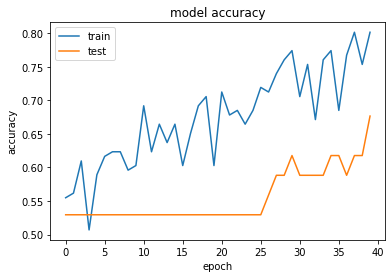

In [ ]:
# lstm 80f submodel training
initial_learning_rate = 0.00001
dropout = 0.9
dense_dropout = 0.9
filter_size = 400
batch_size = 16
tuning_train(X_train_sub, y_train_sub, X_test_sub, y_test_sub, epochs = 40)

Epoch 1/15
10/10 [==============================] - 55s 5s/step - loss: 34.8740 - accuracy: 0.7329 - val_loss: 32.2506 - val_accuracy: 0.7059

Epoch 00001: val_accuracy improved from -inf to 0.70588, saving model to /content/drive/MyDrive/google_colab_skeleton/submodel/80f_lstm_filters400_dropout0.9_densedrop0.9_8ch_lr_sch/bestmodel
INFO:tensorflow:Assets written to: /content/drive/MyDrive/google_colab_skeleton/submodel/80f_lstm_filters400_dropout0.9_densedrop0.9_8ch_lr_sch/bestmodel/assets
Epoch 2/15
10/10 [==============================] - 51s 5s/step - loss: 34.0021 - accuracy: 0.8151 - val_loss: 32.3038 - val_accuracy: 0.6765

Epoch 00002: val_accuracy did not improve from 0.70588
Epoch 3/15
10/10 [==============================] - 46s 5s/step - loss: 35.5518 - accuracy: 0.7397 - val_loss: 32.3244 - val_accuracy: 0.6471

Epoch 00003: val_accuracy did not improve from 0.70588
Epoch 4/15
10/10 [==============================] - 48s 5s/step - loss: 35.0079 - accuracy: 0.7260 - val_los

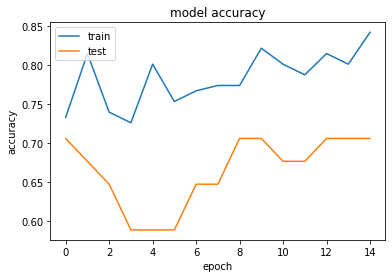

In [ ]:
continue_training_best(X_train_sub, y_train_sub, X_test_sub, y_test_sub, epochs = 15)

Epoch 1/15
10/10 [==============================] - 58s 5s/step - loss: 32.6568 - accuracy: 0.8151 - val_loss: 32.4998 - val_accuracy: 0.6765

Epoch 00001: val_accuracy improved from -inf to 0.67647, saving model to /content/drive/MyDrive/google_colab_skeleton/submodel/80f_lstm_filters400_dropout0.9_densedrop0.9_8ch_lr_sch/bestmodel2nd
INFO:tensorflow:Assets written to: /content/drive/MyDrive/google_colab_skeleton/submodel/80f_lstm_filters400_dropout0.9_densedrop0.9_8ch_lr_sch/bestmodel2nd/assets
Epoch 2/15
10/10 [==============================] - 54s 6s/step - loss: 35.6369 - accuracy: 0.7808 - val_loss: 32.5176 - val_accuracy: 0.6765

Epoch 00002: val_accuracy did not improve from 0.67647
Epoch 3/15
10/10 [==============================] - 48s 5s/step - loss: 33.4852 - accuracy: 0.8151 - val_loss: 32.5676 - val_accuracy: 0.7059

Epoch 00003: val_accuracy improved from 0.67647 to 0.70588, saving model to /content/drive/MyDrive/google_colab_skeleton/submodel/80f_lstm_filters400_dropout

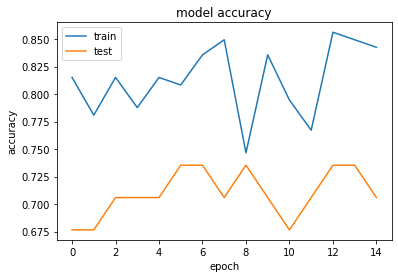

In [ ]:
continue_training_best(X_train_sub, y_train_sub, X_test_sub, y_test_sub, epochs = 15)

In [ ]:
sub_model_path = '/content/drive/MyDrive/google_colab_skeleton/submodel/80f_lstm_filters400_dropout0.9_densedrop0.9_8ch_lr_sch/bestmodel2nd'
sub_model = tf.keras.models.load_model(sub_model_path)

In [ ]:
y_pred_sub = sub_model.predict(X_test_sub)
y_pred_sub_argmax = np.argmax(y_pred_sub, axis = 1)
y_test_sub_argmax = np.argmax(np.array(y_test_sub), axis = 1)
print(classification_report(y_test_sub_argmax, y_pred_sub_argmax))

              precision    recall  f1-score   support

           0       0.68      0.94      0.79        18
           1       0.89      0.50      0.64        16

    accuracy                           0.74        34
   macro avg       0.78      0.72      0.72        34
weighted avg       0.78      0.74      0.72        34

